In [1]:
from pycuda.autoinit import context
import pycuda.driver as drv
from pycuda import cumath
from pycuda import gpuarray
import os
os.environ["CUDA_DEVICE"] = "3"
import scikits.cuda.fft as cu_fft

from scipy.optimize import curve_fit

In [2]:
from pypic import PyPIC_GPU as PIC
from meshing import RectMesh3D
from poisson_solver import FFT_solver as FFT
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import e, epsilon_0
%matplotlib inline


PyKLU not found


In [3]:
import sys
sys.path.append('../')
sys.path.append('old/')

import matplotlib.pyplot as plt

import FFT_OpenBoundary_SquareGrid as PIC_FFT
import geom_impact_poly as poly
import geom_impact_ellip as ell
from scipy import rand
import numpy as np

In [4]:
# define mesh, poissonsolver and PIC
#mesh = RectMesh3D(0., 0., 0., 0.1, 0.1, 0.1, nx=256, ny=256, nz=32, mathlib=cumath)
#nx, ny, nz = 64, 128, 256
nx, ny, nz = 128, 128, 128

dx = dy = dz = 0.15
#dy = 0.3*dx
x_aper = nx*dx/2.
y_aper = ny*dy/2.
z_aper = nz*dz/2.
mesh = RectMesh3D(-x_aper, -y_aper, -z_aper , dx, dy, dz, nx, ny, nz, mathlib=cumath)
print mesh.x0
print mesh.x0 + mesh.nx*mesh.dx
poissonsolver = FFT.GPU_FFT_OpenBoundary(mesh, True)
#poissonsolver_numpyfft = FFT.DEBUG_FFT3_OpenBoundary(mesh, True)
pic = PIC(mesh, poissonsolver, context=context)
#pic = PIC(mesh, poissonsolver_numpyfft, context=context)


poissonsolver2d = FFT.FFT_OpenBoundary_SquareGrid(x_aper=x_aper, y_aper=y_aper, Dh=mesh.dx)
pic_2d = PIC(mesh, poissonsolver2d,context=context)


-9.6
9.6
Using PyFFTW


In [5]:
# generate particles inside mesh
np.random.seed(0)
mesh_center_x = mesh.x0 + 0.5*mesh.nx*mesh.dx
mesh_center_y = mesh.y0 + 0.5*mesh.ny*mesh.dy
mesh_center_z = mesh.z0 + 0.5*mesh.nz*mesh.dz
N = 500*1024
sigma = 0.2
xx = np.random.normal(mesh_center_x, sigma, N)
yy = np.random.normal(mesh_center_y, sigma, N)
#zz = np.random.normal(mesh_center_z, sigma, N)
zz = np.random.uniform(mesh.z0+dz, mesh.z0+mesh.dz*mesh.nz-mesh.dz,N)

assert((xx > mesh.x0).all() and (xx < mesh.x0 + mesh.nx*mesh.dx).all())
assert((yy > mesh.y0).all() and (yy < mesh.y0 + mesh.ny*mesh.dy).all())
assert((zz > mesh.z0).all() and (zz < mesh.z0 + mesh.nz*mesh.dz).all())
xx = gpuarray.to_gpu(xx)
yy = gpuarray.to_gpu(yy)
zz = gpuarray.to_gpu(zz)

In [6]:
# nx, ny, nz = 3, 4, 5
# d_src = gpuarray.zeros((nz, ny, nx), dtype=np.float64)
# print d_src.strides
# print d_src.shape
# d_dst = gpuarray.zeros((5,5,5), dtype=np.float64) + 1
# cpy = drv.Memcpy3D()
# cpy.set_src_device(d_src.ptr)
# cpy.width_in_bytes = d_src.strides[2]*2 # how many bytes per row to copy
# cpy.height = 1#3 # number of rows to copy
# cpy.depth  = 5#5
# cpy.src_pitch = d_src.strides[1] #size of a row in bytes at src
# cpy.dst_pitch = d_dst.strides[1] #size of a row in bytes at dst
# cpy.set_dst_device(d_dst.ptr)
# cpy.src_height = ny
# cpy.dst_height = 5
# cpy()
# a = d_dst.get()
# print(a)
# print d_dst.strides

In [7]:
def create_circular_mesh_charge(mesh, R, charge_per_node=1):
    mesh_charges = np.zeros((mesh.nz, mesh.ny, mesh.nx),dtype=np.float64)
    R2 = R*R
    x_pos = np.arange(mesh.x0, mesh.x0+mesh.nx*mesh.dx, mesh.dx)
    y_pos = np.arange(mesh.y0, mesh.y0+mesh.ny*mesh.dy, mesh.dy)
    z_pos = np.arange(mesh.z0, mesh.z0+mesh.nz*mesh.dz, mesh.dz)

    for k in xrange(mesh.nz):
        for j in xrange(mesh.ny):
            for i in xrange(mesh.nx):
                inside = x_pos[i]**2 + y_pos[j]**2 + z_pos[k]**2 < R2
                if inside:
                    mesh_charges[k,j,i] = charge_per_node
    return mesh_charges
    

def test_solver(new_solver, xx, yy, zz, charge=e, x_probe=None, y_probe=None, z_probe=None):
    '''
    Return rho, Phi, efx, efy, Ex, Ey
    '''
    if x_probe == None:
        x_probe = xx
    if y_probe == None:
        y_probe = yy
    if z_probe == None:
        z_probe = zz
    mesh_charges = new_solver.particles_to_mesh(xx, yy, zz, charge=charge)
    
    #mesh_charges_circle = gpuarray.to_gpu(create_circular_mesh_charge(mesh=mesh, R=5.))
    #mesh_charges = mesh_charges_circle
    rho = mesh_charges/new_solver.mesh.volume_elem
    phi = new_solver.poisson_solve(rho)
    mesh_e_fields = new_solver.get_electric_fields(phi)
    efx = mesh_e_fields[0]
    efy = mesh_e_fields[1]
    efz = mesh_e_fields[2]
    #for i, field in enumerate(mesh_e_fields):
        #mesh_e_fields[i] = field.flatten()
    mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [x_probe, y_probe, z_probe])
    fields = new_solver.field_to_particles(*mesh_fields_and_mp_coords)
    Ex = fields[0]
    Ey = fields[1]
    Ez = fields[2]
    return rho, phi, efx, efy, efz, Ex, Ey, Ez
    #return rho, phi

rho, phi, efx, efy, efz, Ex, Ey, Ez = test_solver(pic, xx, yy, zz)

#rho, phi = test_solver(pic, xx, yy, zz)
print rho.shape
print phi.shape



[128, 128, 128]
[128, 128, 128]


In [8]:
#old version of giannis solver
picFFT = PIC_FFT.FFT_OpenBoundary_SquareGrid(x_aper=x_aper, y_aper=y_aper, Dh = mesh.dx, fftlib='pyfftw')
nel_part = np.zeros(len(xx.get()))+1
picFFT.scatter(xx.get(), yy.get(), nel_part, charge=e)
# substitute rho with the circular charge
print picFFT.rho.T.shape
ny, nx = picFFT.rho.T.shape
R2 = 5.**2
# rho_gianni = 0*picFFT.rho
# for j in xrange(ny):
#     for i in xrange(nx):
#         inside = picFFT.xg[i]**2 + picFFT.yg[j]**2 < R2
#         if inside:
#             rho_gianni[j,i] = 1./(picFFT.dx*picFFT.dy*picFFT.Dh)
# picFFT.rho = rho_gianni
print picFFT.dx, picFFT.dy, picFFT.Dh
picFFT.solve()

Start PIC init.:
FFT, Open Boundary, Square Grid
PyPIC Version 1.02
Using PyFFTW
(135, 137)
0.15 0.15 0.15


In [9]:
print poissonsolver2d.Nxg, poissonsolver2d.Nyg
rho_ = rho.get()[mesh.nz//2]
rho_big = np.zeros((mesh.ny+1,mesh.nx+1), dtype=np.float64)
rho_big[1:, 1:] = rho_
phi_2d = poissonsolver2d.poisson_solve(rho_big*mesh.volume_elem)


129 129


(128, 128, 128)


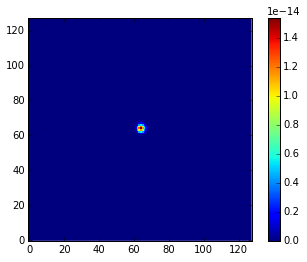

[128, 128, 128]


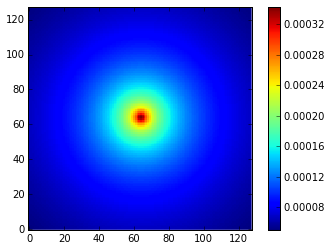

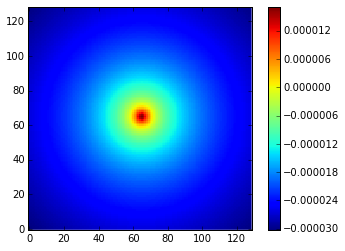

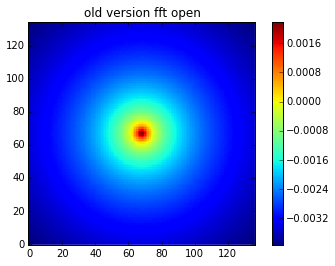

In [10]:
%matplotlib inline

print rho.get().shape
plt.imshow(rho.get()[mesh.nz//2], origin='lower', interpolation='none')
plt.colorbar()
plt.show()

#print phi.get().shape
print phi.shape

plt.imshow(phi.get()[mesh.nz//2], origin='lower', interpolation='none')
#plt.imshow(phi[mesh.nz//2], origin='lower', interpolation='none')

plt.colorbar()
plt.show()

plt.imshow(phi_2d.reshape(mesh.ny+1, mesh.nx+1), origin='lower', interpolation='none')
#plt.imshow(phi[mesh.nz//2], origin='lower', interpolation='none')

plt.colorbar()
plt.show()


plt.imshow(picFFT.phi.T, origin='lower', interpolation='none')
plt.title('old version fft open')
plt.colorbar()
plt.show()

# 



In [11]:
def _phin_round(x, y, z, sig_r):
    '''Return phi / Q for a round distribution with
    sigma_x == sigma_y == sigma_z == sig_r .
    '''
    r = np.sqrt(x**2 + y**2 + z**2)
    return erf(r/(np.sqrt(2)*sig_r)) / (4*np.pi*epsilon_0 * r)

In [12]:
def plot_potential_fft_open(h_field_FFT, analytic, extent,
                         x_label='$x$', y_label='$y$', z_label='$phi$'):
    print extent
    plt.figure(figsize=(10,4))
    subplots_x = 25
    ax1 = plt.subplot2grid((1,subplots_x), (0,0), colspan=10)
    s1 = ax1.contourf(h_field_FFT, cmap=plt.get_cmap('rgb'), 
                    origin='lower', interpolation='none',
                    extent=extent)
    plt.title(z_label + ' FFT', fontsize=20)
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    
    ax3 = plt.subplot2grid((1,subplots_x), (0,10))
    cbar1 = plt.colorbar(s1, cax=ax3)
    cbar1.set_label(z_label, fontsize=18)
    
    ax2 = plt.subplot2grid((1,subplots_x), (0,13), colspan=10, sharey=ax1)
    s2 = ax2.contourf(analytic, cmap=plt.get_cmap('rgb'), 
                    origin='lower', interpolation='none',
                    extent=extent)
    plt.title('Analytic', fontsize=20)
    plt.xlabel(x_label, fontsize=18)
    
    ax4 = plt.subplot2grid((1,subplots_x), (0,23))
    cbar2 = plt.colorbar(s2, cax=ax4)
    cbar2.set_label(z_label, fontsize=18)

    
    plt.subplots_adjust(hspace=0)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.show()


In [13]:
from matplotlib.colors import LinearSegmentedColormap
cdict  = {'red':  ((0.0, 0.0, 0.0),
                   (0.25,0.125, 0.125),
                   (0.5, 0.5, 0.5),
                   (0.75,0.5, 0.5),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (0.25,0.5, 0.5),
                   (0.5, 1.0, 1.0),
                   (0.75,0.5, 0.5),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25,0.5, 0.5),
                   (0.5, 0.5, 0.5),
                   (0.75,0.125, 0.125),
                   (1.0, 0.0, 0.0))#,

        }
plt.register_cmap(name='rgb', data=cdict)

-9.6 -9.6 -9.6
[-9.6  9.6 -9.6  9.6 -9.6  9.6]
[-9.6  9.6 -9.6  9.6]


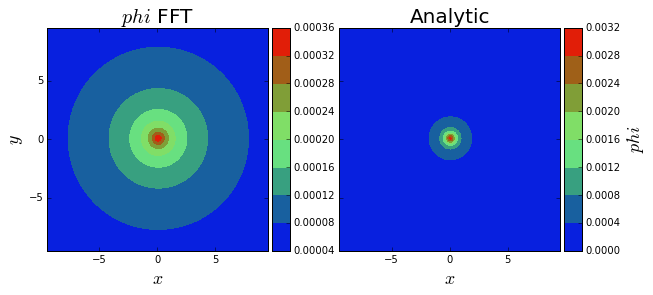

[-9.6  9.6 -9.6  9.6]


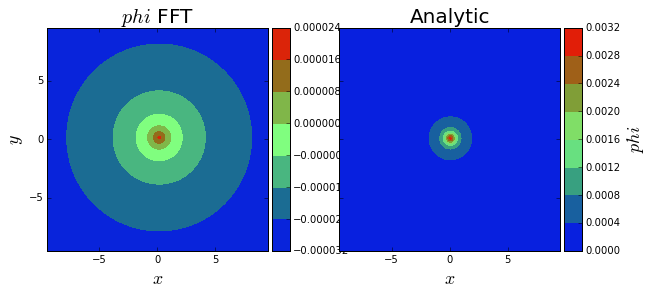

[-9.6  9.6 -9.6  9.6]


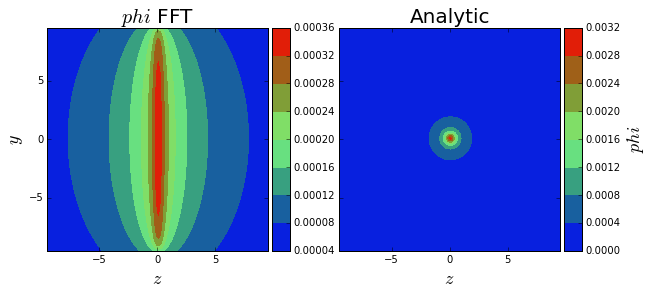

In [14]:
from scipy.special import erf
extent = np.array([mesh.x0, mesh.x0+mesh.nx*mesh.dx,
                   mesh.y0, mesh.y0+mesh.ny*mesh.dy,
                   mesh.z0, mesh.z0+mesh.nz*mesh.dz])
print mesh.x0, mesh.y0, mesh.z0
print extent
z, y, x = np.meshgrid(np.linspace(extent[4], extent[5], mesh.nz),
                      np.linspace(extent[2], extent[3], mesh.ny),
                      np.linspace(extent[0], extent[1], mesh.nx),
                      indexing="ij")
xr = x - mesh_center_x - 0.5*mesh.dx
yr = y - mesh_center_y - 0.5*mesh.dy
zr = z - mesh_center_z - 0.5*mesh.dz
sig_x = sigma
phi_analytic = _phin_round(xr, yr, zr, sig_x) * N * e
plot_potential_fft_open(phi.get()[mesh.nz//2], 
                     phi_analytic[mesh.nz//2], extent=extent[0:4],
                     x_label='$x$', y_label='$y$', z_label='$phi$')

plot_potential_fft_open(phi_2d.reshape(mesh.ny+1, mesh.nx+1).T, 
                     phi_analytic[mesh.nz//2], extent=extent[0:4],
                     x_label='$x$', y_label='$y$', z_label='$phi$')

plot_potential_fft_open(phi.get()[:,:,mesh.nx//2], 
                     phi_analytic[:,:,mesh.nx//2], extent=extent[[4,5,2,3]],
                     x_label='$z$', y_label='$y$', z_label='$phi$')

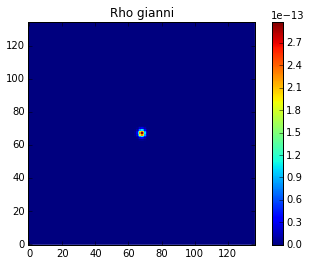

34


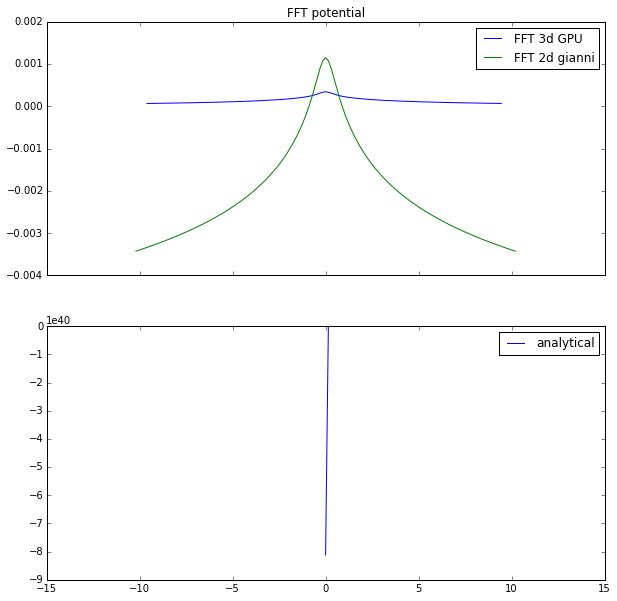

In [15]:
def phi_analytical_sphere_1d(x,rho, c=0):
    return -rho/x**3 + c


xxx = np.arange(mesh.x0, mesh.x0+mesh.nx*mesh.dx, dx)
xxx_old = picFFT.xg

plt.imshow(picFFT.rho.T, origin='lower', interpolation='none')
plt.colorbar()
plt.title('Rho gianni')
plt.show()

f, axarr = plt.subplots(2, sharex=True)
f.set_figheight(10)
f.set_figwidth(10)
x_rhs = xxx[xxx>0]
x_rhs = x_rhs[x_rhs < np.sqrt(R2)]
print len(x_rhs)
axarr[0].set_title('FFT potential')
axarr[0].plot(xxx,phi.get()[mesh.nz//2, mesh.ny//2,:],label = 'FFT 3d GPU')
axarr[0].plot(xxx_old,picFFT.phi.T[mesh.ny//2,:],label = 'FFT 2d gianni')
axarr[0].legend()
axarr[1].plot(x_rhs, phi_analytical_sphere_1d(x_rhs, rho=1), label='analytical')
axarr[1].legend()
plt.show()


128
(61,)
[ 0.00027342] [ -1.21820178e-05   1.48512026e-06] [ 0.00073064]
[ 0.3742154]


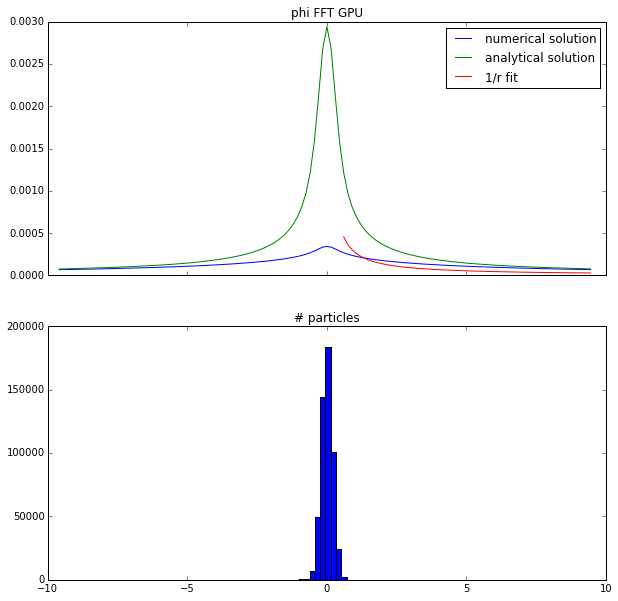

/home/oeftiger/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


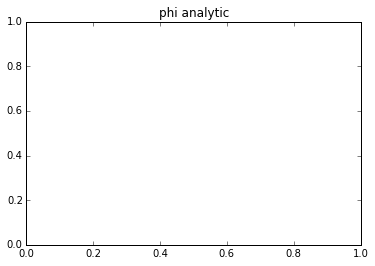

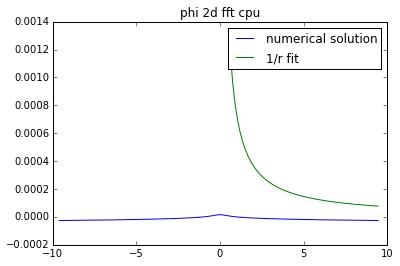

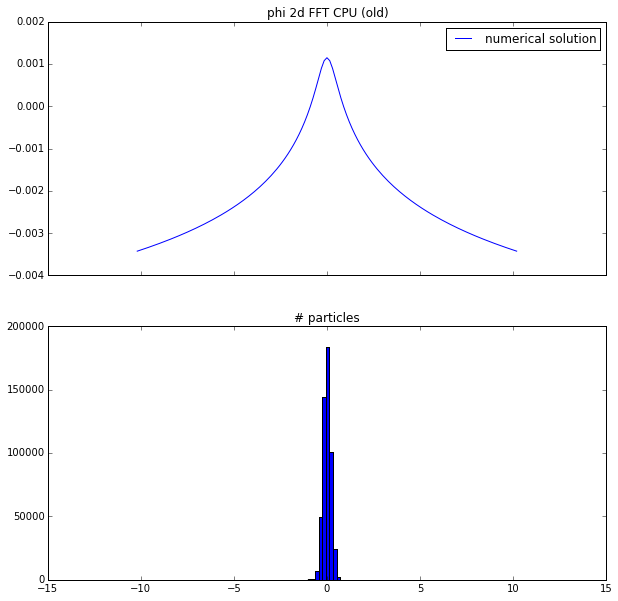

In [16]:
xxx = np.arange(mesh.x0, mesh.x0+mesh.nx*mesh.dx, dx)
start_fit = mesh.nx/2 + 4
fit_xxx = xxx[start_fit:]
print(len(xxx))
phi_2d = phi_2d.reshape(mesh.ny+1, mesh.nx+1)
print phi_2d[ny//2,start_fit:].shape
def fn(r, a):
    return a*(1./r)

def fn_log(r,a, b):
    return a*np.log(r) + b

popt_GPU, _ = curve_fit(fn, fit_xxx, phi.get()[mesh.nz//2, mesh.ny//2, start_fit:])
popt_CPU, _ = curve_fit(fn_log, fit_xxx, phi_2d[mesh.ny//2, start_fit:-1])
#popt_CPU_old, _ = curve_fit(fn, fit_xxx, picFFT.phi.T[mesh.ny//2, start_fit:-1])

popt_analytic, _ = curve_fit(fn, fit_xxx, phi_analytic[mesh.nz//2, mesh.ny//2, start_fit:])
print popt_GPU, popt_CPU, popt_analytic
print popt_GPU/popt_analytic

f, axarr = plt.subplots(2, sharex=True)
f.set_figheight(10)
f.set_figwidth(10)

axarr[0].set_title('phi FFT GPU')
axarr[0].plot(xxx,phi.get()[mesh.nz//2, mesh.ny//2,:],label = 'numerical solution')
axarr[0].plot(xxx, phi_analytic[mesh.nz//2, mesh.ny//2, :], label= 'analytical solution')
axarr[0].plot(fit_xxx, fn(fit_xxx, *popt_GPU), label='1/r fit')
#axarr[0].plot(fit_xxx, 1./(4*np.pi*epsilon_0*fit_xxx), label='1/r')

axarr[0].legend()
axarr[1].set_title('# particles')
axarr[1].hist(xx.get())#,weights=np.ones(len(xx.get))*np.max(phi.get()[mesh.nx//2, mesh.ny//2,:]))
plt.show()
#plt.plot(xxx,phi_analytic[mesh.nz//2, mesh.ny//2,:], label='analytic solution')
#plt.plot(fit_xxx, fn(fit_xxx, *popt_analytic), label='1/r fit')

plt.legend()
plt.title('phi analytic')
plt.show()
plt.plot(xxx,phi_2d[mesh.ny//2,1:], label='numerical solution')
plt.plot(fit_xxx, fn(fit_xxx, *popt_analytic), label='1/r fit')
plt.legend()
plt.title('phi 2d fft cpu')
plt.show()
# plt.plot(picFFT.phi.T[mesh.ny//2,1:])
# #plt.plot(fit_xxx, fn(fit_xxx, *popt_CPU))
# plt.title('phi 2d fft cpu old')
# plt.show()

f, axarr = plt.subplots(2, sharex=True)
f.set_figheight(10)
f.set_figwidth(10)

axarr[0].set_title('phi 2d FFT CPU (old)')
xxx_old = picFFT.xg
axarr[0].plot(xxx_old,picFFT.phi.T[mesh.ny//2,:],label = 'numerical solution')
axarr[0].legend()
axarr[1].set_title('# particles')
axarr[1].hist(xx.get())#,weights=np.ones(len(xx.get))*np.max(phi.get()[mesh.nx//2, mesh.ny//2,:]))
plt.show()

In [17]:
np.max(phi.get()/phi_analytic)

3.2766565043079159

In [18]:
np.min(phi.get()/phi_analytic)

0.11677982068370082

In [19]:
phi.get()[mesh.nz//2]/phi_2d.reshape(129, 129)[1:,1:]
phi.get()[mesh.nz//2]-phi_2d.reshape(129, 129)[1:,1:]
print phi.get()[mesh.nz//2]/phi_analytic[mesh.nz//2]


[[ 0.94017948  0.93928874  0.93838859 ...,  0.93757087  0.93848058
   0.93938104]
 [ 0.93928849  0.93837372  0.93744895 ...,  0.93660724  0.93754216
   0.93846723]
 [ 0.93838808  0.93744869  0.93649867 ...,  0.93563234  0.93659312
   0.93754342]
 ..., 
 [ 0.93754066  0.93657702  0.93560212 ...,  0.93471254  0.93569882
   0.93667397]
 [ 0.9384504   0.93751197  0.93656293 ...,  0.93569859  0.93665836
   0.93760767]
 [ 0.93935089  0.93843707  0.93751325 ...,  0.93667351  0.93760744
   0.93853153]]


In [20]:
(0.15**3)

0.0033749999999999995

In [21]:
save_phi = phi.get()

In [22]:
print sum(sum(sum(rho.get())))*mesh.volume_elem
print N*e

8.2031440128e-14
8.2031440128e-14
